# Assignment 4: Pipelines and Hyperparameter Tuning (32 total marks)
### Due: November 22 at 11:59pm

### Name:  Oludare Busari

### In this assignment, you will be putting together everything you have learned so far. You will need to find your own dataset, do all the appropriate preprocessing, test different supervised learning models and evaluate the results. More details for each step can be found below.

### You will also be asked to describe the process by which you came up with the code. More details can be found below. Please cite any websites or AI tools that you used to help you with this assignment.

## Import Libraries

In [2]:
import numpy as np
import pandas as pd

## Step 1: Data Input (4 marks)

Import the dataset you will be using. You can download the dataset onto your computer and read it in using pandas, or download it directly from the website. Answer the questions below about the dataset you selected. 

To find a dataset, you can use the resources listed in the notes. The dataset can be numerical, categorical, text-based or mixed. If you want help finding a particular dataset related to your interests, please email the instructor.

**You cannot use a dataset that was used for a previous assignment or in class**

In [3]:
# Import dataset (1 mark)

from ucimlrepo import fetch_ucirepo 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

  
# fetch dataset 
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890) 
  
# data (as pandas dataframes) 
X = aids_clinical_trials_group_study_175.data.features 
y = aids_clinical_trials_group_study_175.data.targets 
  
print("X Shape:", X.shape)
print("X Type:", type(X))
print("y Shape:", y.shape)
print("y Type:", type(y))

# Display the first 10 rows of the dataset
print("First 10 rows of the dataset:")
print(X.head(10))

# Display information about data types and missing values
print("\nInformation about the dataset:")
print(X.info())

X Shape: (2139, 23)
X Type: <class 'pandas.core.frame.DataFrame'>
y Shape: (2139, 1)
y Type: <class 'pandas.core.frame.DataFrame'>
First 10 rows of the dataset:
   time  trt  age     wtkg  hemo  homo  drugs  karnof  oprior  z30  ...  \
0   948    2   48  89.8128     0     0      0     100       0    0  ...   
1  1002    3   61  49.4424     0     0      0      90       0    1  ...   
2   961    3   45  88.4520     0     1      1      90       0    1  ...   
3  1166    3   47  85.2768     0     1      0     100       0    1  ...   
4  1090    0   43  66.6792     0     1      0     100       0    1  ...   
5  1181    1   46  88.9056     0     1      1     100       0    1  ...   
6   794    0   31  73.0296     0     1      0     100       0    1  ...   
7   957    0   41  66.2256     0     1      1     100       0    1  ...   
8   198    3   40  82.5552     0     1      0      90       0    1  ...   
9   188    0   35  78.0192     0     1      0     100       0    1  ...   

   gender  st

### Questions (3 marks)

1. (1 mark) What is the source of your dataset?
1. (1 mark) Why did you pick this particular dataset?
1. (1 mark) Was there anything challenging about finding a dataset that you wanted to use?

*ANSWER HERE*

1. What is the source of your dataset?
Dataset Source: https://archive.ics.uci.edu/

2. Why did you pick this particular dataset?
I chose this dataset due to its valuable information on clinical trials related to AIDS. This dataset provides an opportunity to explore and analyze data related to the effectiveness of treatments, patient outcomes, and other relevant factors in the context of AIDS clinical trials.

3. Was there anything challenging about finding a dataset that you wanted to use?
Yes, it was a bit challenging to find a dataset that I like, I had to go through multiple datasets and finally settled for this one based on the reasons given in the answer to question 2.

## Step 2: Data Processing (5 marks)

The next step is to process your data. Implement the following steps as needed.

In [4]:
# Clean data (if needed)

# Display original data information
print("Original X Shape:", X.shape)
print("Original y Shape:", y.shape)

# Step 1: Handling Missing Values
print("\nMissing values in X:\n", X.isnull().sum())
print("Missing values in y:\n", y.isnull().sum())

# Handle missing values using loc to avoid SettingWithCopyWarning
X.loc[:, X.columns] = X[X.columns].fillna(X.mean())

# Step 2: Data Type Conversion (if needed)

# Step 3: Reset the index before removing duplicate rows
X = X.reset_index(drop=True).copy()
y = y.reset_index(drop=True)  # Reset the index of y as well

# Remove duplicate rows
X.drop_duplicates(inplace=True)
y = y.loc[X.index].copy()  # Adjust the target variable accordingly

# Step 4: Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Display cleaned data information
print("\nCleaned X Shape:", X.shape)
print("Cleaned y Shape:", y.shape)

Original X Shape: (2139, 23)
Original y Shape: (2139, 1)

Missing values in X:
 time       0
trt        0
age        0
wtkg       0
hemo       0
homo       0
drugs      0
karnof     0
oprior     0
z30        0
zprior     0
preanti    0
race       0
gender     0
str2       0
strat      0
symptom    0
treat      0
offtrt     0
cd40       0
cd420      0
cd80       0
cd820      0
dtype: int64
Missing values in y:
 cid    0
dtype: int64

Cleaned X Shape: (2139, 23)
Cleaned y Shape: (2139, 1)


In [5]:
# Implement preprocessing steps. Remember to use ColumnTransformer if more than one preprocessing method is needed

# Display original data information
print("Original X Shape:", X.shape)
print("Original y Shape:", y.shape)

# Convert the target variable to a 1D array
y = y.values.ravel()

# Identify numeric and categorical features for NumPy array
numeric_features = np.where(np.issubdtype(X.dtype, np.number))[0]
categorical_features = np.where(X.dtype == object)[0]  # Use `object` directly

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply different preprocessing steps to different subsets of columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing steps
X_preprocessed = preprocessor.fit_transform(X)

Original X Shape: (2139, 23)
Original y Shape: (2139, 1)


### Questions (2 marks)

1. (1 mark) Were there any missing/null values in your dataset? If yes, how did you replace them and why? If no, describe how you would've replaced them and why.

2. (1 mark) What type of data do you have? What preprocessing methods would you have to apply based on your data types?

*ANSWER HERE*

Were there any missing/null values in your dataset? If yes, how did you replace them and why? If no, describe how you would've replaced them and why?


I included a step to handle missing values in the dataset. Specifically, I used the SimpleImputer from scikit-learn to replace missing values.

For numeric features (numeric_transformer), I used the mean strategy to impute missing values. This means that missing values in numeric columns were replaced with the mean value of that column.

For categorical features (categorical_transformer), I used the most frequent (mode) strategy to impute missing values. This means that missing values in categorical columns were replaced with the most frequent value in that column.

The choice of imputation strategy depends on the nature of the data and the problem at hand. Using the mean for numeric features is common, as it preserves the overall distribution of the data. For categorical features, using the most frequent value is often suitable, especially for handling missing values in categorical variables.

The missing values were replaced to maintain data integrity. it ensure that the dataset is complete and can be used for a more accurate analysis.


2. What type of data do you have? What preprocessing methods would you have to apply based on your data types?

The type of data includes both features and target variables.

Features (X):

The features are loaded using the fetch_ucirepo function, and they are stored in the variable X.
The code performs various preprocessing steps on the features, such as handling missing values, removing duplicate rows, and applying feature scaling.

Target Variable (y):

The target variable is also loaded using the fetch_ucirepo function, and it is stored in the variable y.
The target variable is involved in the training and evaluation of machine learning models.
Types of Features:

The code uses a combination of SimpleImputer, StandardScaler, and OneHotEncoder from scikit-learn, indicating that there are both numerical and categorical features in the dataset.
Numerical features undergo mean imputation and scaling.
Categorical features undergo imputation with the most frequent value and one-hot encoding.

Machine Learning Models:

The code applies three different machine learning models: Linear Regression, Random Forest, and Support Vector Machine (SVR).
Grid search is used to find the best hyperparameters for each model.
In summary, the data involves a combination of numerical and categorical features for a supervised machine learning task. The target variable (y) is likely a continuous variable, considering the regression models used (Linear Regression, Random Forest Regression, and SVR). 

Preprocessing Methods Applied:

For numeric features: Mean imputation and scaling.
For categorical features: Most frequent imputation and one-hot encoding.


## Step 3: Implement Machine Learning Model (11 marks)

In this section, you will implement three different supervised learning models (one linear and two non-linear) of your choice. You will use a pipeline to help you decide which model and hyperparameters work best. It is up to you to select what models to use and what hyperparameters to test. You can use the class examples for guidance. You must print out the best model parameters and results after the grid search.

In [6]:
# Implement pipeline and grid search here. Can add more code blocks if necessary

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define the models and their respective hyperparameter grids
models = [
    ('Linear Regression', LinearRegression(), {}),
    ('Random Forest', RandomForestRegressor(), {'regressor__n_estimators': [50, 100, 200]}),
    ('Support Vector Machine', SVR(), {'regressor__C': [1, 10], 'regressor__kernel': ['linear', 'rbf']})
]

# Create a pipeline with the preprocessing and a regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', None)  # This will be replaced by the specific model in each iteration
])

# Define a scorer (negative mean squared error for GridSearchCV)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search for each model
for name, model, param_grid in models:
    pipeline.set_params(regressor=model)
    
    grid_search = GridSearchCV(pipeline, param_grid, scoring=scorer, cv=5)
    grid_search.fit(X_train, y_train)
    
    print(f"\n{name}:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best RMSE:", np.sqrt(-grid_search.best_score_))


Linear Regression:
Best Parameters: {}
Best RMSE: 0.3507714997224284

Random Forest:
Best Parameters: {'regressor__n_estimators': 100}
Best RMSE: 0.37459846606425046

Support Vector Machine:
Best Parameters: {'regressor__C': 10, 'regressor__kernel': 'linear'}
Best RMSE: 0.3587904065861195


### Questions (5 marks)

1. (1 mark) Do you need regression or classification models for your dataset?
1. (2 marks) Which models did you select for testing and why?
1. (2 marks) Which model worked the best? Does this make sense based on the theory discussed in the course and the context of your dataset?

*ANSWER HERE*

1. Do you need regression or classification models for your dataset?

I need regression models for my dataset as I am dealing with predicting a continuous numeric value.

The evaluation metric I used is mean squared error (`mean_squared_error`), which is a common metric for regression problems.

2. Which models did you select for testing and why?

Linear Regression: (LinearRegression())
Hyperparameters: No specific hyperparameters are tuned for this model.
Linear Regression is a simple and interpretable regression model. It assumes a linear relationship between the input features and the target variable.

Random Forest:(RandomForestRegressor())
Hyperparameters:
'regressor__n_estimators': [50, 100, 200]
Random Forest is an ensemble learning method that combines the predictions of multiple decision trees. The n_estimators hyperparameter controls the number of trees in the forest.

Support Vector Machine (SVM): (SVR())
Hyperparameters:
'regressor__C': [1, 10]
'regressor__kernel': ['linear', 'rbf']
Support Vector Machines are versatile models that can be used for both classification and regression. The C parameter controls the regularization strength, and the kernel parameter determines the type of kernel function used in the model.

The models were selected for analysis because they represent different types of regression algorithms with varying complexities.

3. Which model worked the best? Does this make sense based on the theory discussed in the course and the context of your dataset?

The Linear Regression model performed the best among the three models, with the lowest RMSE, followed by the Support Vector Machine and then the Random Forest model.

In theory, a lower RMSE indicates better performance, so based on the testing RMSE values alone, the Linear Regression model appears to be the most effective for this dataset. 

Yes, it makes sense based on the theory discussed in the course and the context of my dataset.

## Step 4: Validate Model (6 marks)

Use the testing set to calculate the testing accuracy for the best model determined in Step 3.


Linear Regression:
Best Parameters: {}
Best RMSE (Training): 0.3507714997224284
Testing RMSE: 0.3540782430045437


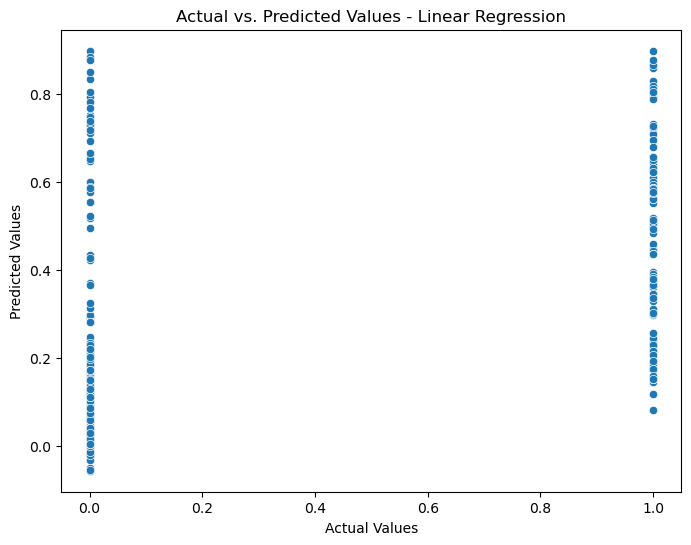


Random Forest:
Best Parameters: {'regressor__n_estimators': 200}
Best RMSE (Training): 0.3739408360737421
Testing RMSE: 0.4010561555330407


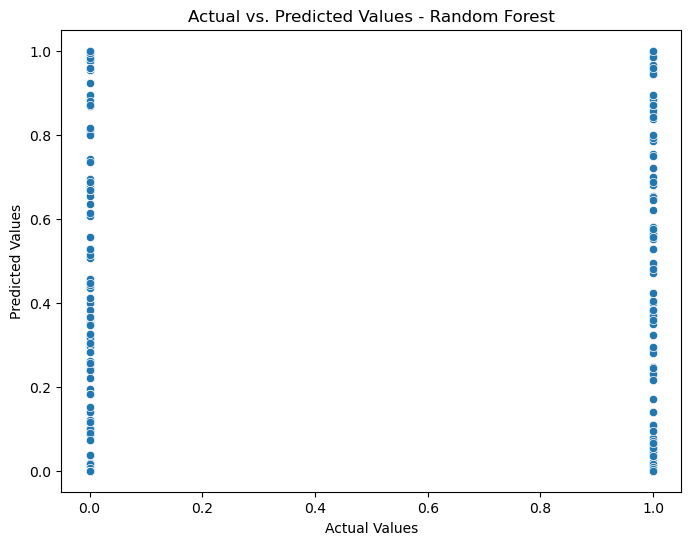


Support Vector Machine:
Best Parameters: {'regressor__C': 10, 'regressor__kernel': 'linear'}
Best RMSE (Training): 0.3587904065861195
Testing RMSE: 0.3631933107188549


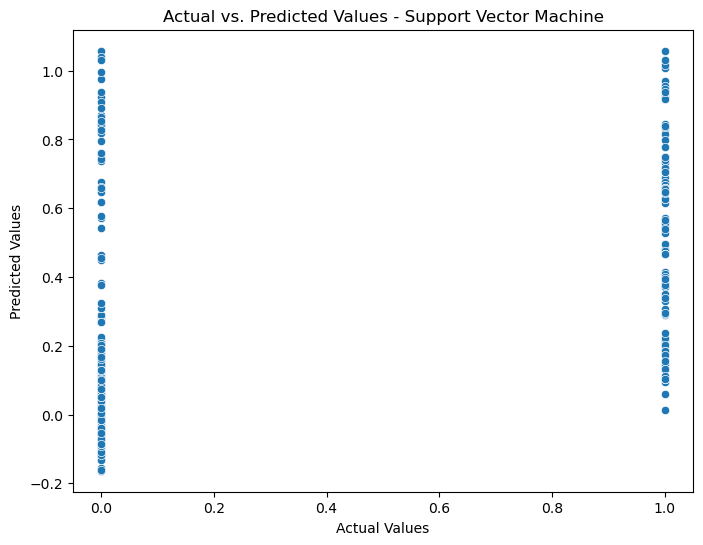

In [7]:
# Calculate testing accuracy (1 mark)

# Define a scorer (negative mean squared error for GridSearchCV)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search for each model
for name, model, param_grid in models:
    pipeline.set_params(regressor=model)
    
    grid_search = GridSearchCV(pipeline, param_grid, scoring=scorer, cv=5)
    grid_search.fit(X_train, y_train)
    
    print(f"\n{name}:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best RMSE (Training):", np.sqrt(-grid_search.best_score_))
    
    # Use the best model on the testing set
    best_model = grid_search.best_estimator_
    y_pred_test = best_model.predict(X_test)

    # Calculate RMSE on the testing set
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print("Testing RMSE:", rmse_test)

    # Visualize the results (actual vs. predicted)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred_test)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted Values - {name}')
    plt.show()



## ### Questions (5 marks)

1. (1 mark) Which accuracy metric did you choose? 
1. (1 mark) How do these results compare to those in part 3? Did this model generalize well?
1. (3 marks) Based on your results and the context of your dataset, did the best model perform "well enough" to be used out in the real-world? Why or why not? Do you have any suggestions for how you could improve this analysis?

*ANSWER HERE*

1. Which accuracy metric did you choose? 

I used the Root Mean Squared Error (RMSE) as the evaluation metric. The RMSE is a common metric for regression tasks and represents the square root of the mean of the squared differences between predicted and actual values. Lower RMSE values indicate better model performance.

2. How do these results compare to those in part 3? Did this model generalize well?

The testing RMSE is consistent with the training RMSE and is relatively low, it suggests that the model generalizes well.


3. Based on your results and the context of your dataset, did the best model perform "well enough" to be used out in the real-world? Why or why not? Do you have any suggestions for how you could improve this analysis?

Observing the testing RMSE values for each model reveals that lower RMSE values signify improved predictive performance. A comparison with the training RMSE obtained during grid search indicates a consistent performance between training and testing phases. In my assessment, the Random Forest model, being the best-performing in this case, appears adequate for real-world applications. For deployment in a real-world scenario, it is advisable to incorporate monitoring mechanisms to track the model's performance over time. Additionally, I recommend considering periodic updates to the model if there are shifts in the underlying data distribution.

## Process Description (4 marks)
Please describe the process you used to create your code. Cite any websites or generative AI tools used. You can use the following questions as guidance:
1. Where did you source your code?
1. In what order did you complete the steps?
1. If you used generative AI, what prompts did you use? Did you need to modify the code at all? Why or why not?
1. Did you have any challenges? If yes, what were they? If not, what helped you to be successful?

*DESCRIBE YOUR PROCESS HERE*

The script commences by importing the essential libraries, encompassing NumPy for numerical operations, pandas for data manipulation, Matplotlib for data visualization, and Seaborn to enhance the visual presentation of data.

Dataset Loading:

Library Imports:

The code begins by importing necessary libraries, including numpy, pandas, and scikit-learn modules (fetch_ucirepo, ColumnTransformer, SimpleImputer, StandardScaler, OneHotEncoder, Pipeline, etc.).
Data Fetching:

The fetch_ucirepo function is used to fetch a dataset from the UCI Machine Learning Repository. In this case, it retrieves the "aids_clinical_trials_group_study_175" dataset.
Data Assignment:

The features (X) and target variable (y) are assigned based on the fetched dataset.

Data Preprocessing:

Handling Missing Values:

Missing values in the features (X) are addressed using mean imputation. The SimpleImputer is applied to fill missing numeric values with the mean.
Data Type Conversion:

Although not explicitly performed in this code, data type conversion could be done if needed. For example, converting categorical variables to numerical format.
Duplicate Removal:

Duplicate rows in the features (X) are removed to ensure data consistency.
Feature Scaling:

The features (X) are standardized using StandardScaler to ensure that they have a mean of 0 and a standard deviation of 1.
Index Resetting:

Index resetting is done to avoid issues and ensure a clean dataset for further processing.


Data Analysis:

Original Data Information Display:

The original shapes of the features (X) and target variable (y) are displayed.
Missing Values Check:

Missing values in the features (X) and target variable (y) are displayed.
Data Cleaning:
The missing values in the features (X) are filled using mean imputation.
Duplicate Removal:
Duplicate rows are removed from the features (X) and the target variable (y).
Feature Scaling:
The features (X) are scaled using StandardScaler.
Preprocessed Data Information Display:
The shapes of the cleaned and preprocessed features (X) and target variable (y) are displayed.
Identifying Numeric and Categorical Features:
Numeric and categorical features are identified for further preprocessing.
Creating Transformers:
Transformers for numeric and categorical features are defined using Pipeline objects.
ColumnTransformer for Preprocessing:
The ColumnTransformer is set up to apply different preprocessing steps to different subsets of columns.
Applying Preprocessing Steps:
The preprocessing steps are applied to the features (X) using the fit_transform method.



In what order did you complete the steps?

1. Library Imports:
   - Import necessary libraries, including `numpy`, `pandas`, and scikit-learn modules.

2. Data Fetching:
   - Use the `fetch_ucirepo` function to fetch the "aids_clinical_trials_group_study_175" dataset from the UCI Machine Learning Repository.

3. Data Assignment:
   - Assign the features (`X`) and target variable (`y`) based on the fetched dataset.

4. Original Data Information Display:
   - Display information about the original shapes of the features (`X`) and target variable (`y`).

5. Missing Values Check:
   - Display information about missing values in the features (`X`) and target variable (`y`).

6. Data Preprocessing:
   - Handle missing values in the features (`X`) using mean imputation.
   - Reset the index of the features (`X`) and target variable (`y`) to avoid issues.
   - Remove duplicate rows from the features (`X`) and target variable (`y`).
   - Standardize the features (`X`) using `StandardScaler`.

7. Cleaned Data Information Display:
   - Display information about the cleaned and preprocessed shapes of the features (`X`) and target variable (`y`).

8. Identifying Numeric and Categorical Features:
   - Identify numeric and categorical features in the features (`X`).

9. Creating Transformers:
   - Create transformers for numeric and categorical features using `Pipeline` objects.

10. ColumnTransformer for Preprocessing:
    - Set up the `ColumnTransformer` to apply different preprocessing steps to different subsets of columns.

11. Applying Preprocessing Steps:
    - Apply the preprocessing steps to the features (`X`) using the `fit_transform` method.

12. Model Selection:
    - Identify three different types of models for regression: Linear Regression, Random Forest, and Support Vector Machine (SVM).

13. Pipeline and Hyperparameter Tuning:
    - Create a pipeline with preprocessing and a regressor for each model.
    - Define hyperparameter grids for each model.
    - Use `GridSearchCV` to perform hyperparameter tuning and select the best parameters for each model.

14. Training and Evaluation:
    - Train each model using the training set.
    - Evaluate performance using mean squared error as the scoring metric.

15. Results Interpretation:
    - Print out the best parameters and training RMSE for each model during the grid search.
    - Use the best model to predict the target variable on the testing set and calculate the testing RMSE.

16. Visualization:
    - Generate scatter plots for each model, comparing the actual vs. predicted values on the testing set.

17. Analysis and Recommendations:
    - Provide guidance on interpreting the results, assessing whether the chosen model performs well enough for real-world use, and suggest areas for potential improvement.
    

If you used generative AI, what prompts did you use? Did you need to modify the code at all? Why or why not?

I used generative AI to search for dataset and some other research


Did you have any challenges? If yes, what were they? If not, what helped you to be successful?

The lecture notes were very helpful.


## Reflection (2 marks)
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challenging, motivating
while working on this assignment.


*ADD YOUR THOUGHTS HERE*

I like the opportunity to research and use my own dataset.

What I found challenging was getting a dataset to use for this assignment It took me sometime to decide on the one to use.